# Comparing Simple Exploration Techniques: ε-Greedy, Annealing, and UCB

> *A quick workshop comparing different exploration techniques.*

Bandit algorithms provide a way to optimize single competing actions in the shortest amount of time. Imagine you are attempting to find out which advert provides the best click through rate of which button provides the most sales. You could show two ads and count the number of clicks on each, over a one week period. But this means that many people would see a sub-optimal ad. Instead, you can learn over time and progressively shift the shown advert towards the one that is performing better.

<p><center><img src='_images/T798984_1.png'></center></p>

## Setup

In [ ]:
!pip install -q banditsbook==0.1.1 pandas==1.1.2 matplotlib==3.3.2

In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import matplotlib
import random

from arms.bernoulli import BernoulliArm
from algorithms.epsilon_greedy.standard import EpsilonGreedy
from algorithms.softmax.annealing import AnnealingSoftmax
from algorithms.ucb.ucb1 import UCB1
from testing_framework.tests import test_algorithm

## Scenario

Imagine you work for an online ecommerce company. Given your role in engineering, you will be expected to develop new features and maintain existing ones. For example, you might be asked to improve the checkout process or migrate to a new library.

But how can you be certain that your changes have the desired effect? Monitoring key performance indicators (KPIs) is one possible solution. For new features you want to positively impact the KPIs. For maintenance tasks you want no impact.

As an example, take the classic scenario of establishing the best color for a button. Which is better, red or green? How do you quantify the difference? To approach this using RL you must define the three core elements of the problem: the reward, the actions, and the environment.

To quantify performance, the result of an action must be measurable. In RL, this is the purpose of the reward. It provides evidence of an outcome, which can be good or bad. Practitioners typically encode good outcomes as positive values (but this is not strictly necessary).

What reward signal should you choose for the website button example? You could say that clicks are a positive outcome. And a sale is a strongly positive outcome. Often you will have limited access to metrics and have to compromise. For example, rather than use the sale as the KPI, you could calculate the average sale for everyone who clicks the button and assign that single value to every click. That way you would not need to integrate with another system.

The action is to choose whether to show the red button or the green button to a visitor, which in mathematical form would be $\mathcal{A} = \{a_{red},a_{green}\}$. Whenever a user visits your website your agent will decide which action to choose, as defined by the current strategy. The user then clicks the button or doesn’t and a reward is sent back to your agent. It’s easiest to imagine the reward being one for a click and zero for no click, for example. But it could easily be the profit made from that customer or any other business metric.

## RL environment

When you work on an industrial project, the best environment is real life. However, your environment may be too expensive, dangerous, or complicated to develop against. Instead, you can build a simulation, which could be a simplified version of a domain (like a three-dimensional gaming engine), or modeled from collected data.

Pretend that the notional website visitors do not click the button every time, only some proportion of the time. Also, they prefer the red button over the green button. In this example, I assume that a whopping 40% of users click the red button, but only 5% of users click the green. But these numbers could come from prior experimentation or a published model.

Define two adverts, with a probability of clicking from the users. This is a simulation. Imagine that these are real ads.

In [ ]:
arm0 = BernoulliArm(0.05)
arm1 = BernoulliArm(0.4)
arms = [arm0, arm1]

This is an important definition, which glosses over a few important aspects. Primarily, these simulations are responsible for providing a reward whenever the simulated person performs an action. Sometimes the reward is a 0, when they don’t click, other times it’s a 1 when they do. Look:

In [ ]:
[arm1.draw() for _ in range(5)]

[0.0, 1.0, 1.0, 0.0, 0.0]

## Running the Experiment With a Random Algorithm
Now we have the “environment” simulated, we can run various algorithms to see how often the optimal action is presented to the user.

A great baseline is a random agent, so let’s try that first.

But I need a bit of supporting code, because I’m not interested in raw decisions. I want to see how often button 2 was chosen. To do this, I will repeat the experiment 1000 times, and measure the proportion of time ad 2 was chosen.

In [ ]:
epsilon = 1 # Choose a random action every time
num_sims = 1000 # Number of repetitions
horizon = 250 # Length of experiment

df = pd.DataFrame() # Buffer
algo1 = EpsilonGreedy(epsilon, [], []) # Algorithm
sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo1, arms, num_sims, horizon) # Running the environment/algorithm via the library
arrays = [[epsilon] * num_sims * horizon, sim_nums, times] # Constructing the output array for aggregation
index = pd.MultiIndex.from_arrays(
        arrays, names=('epsilon', 'simulation', 'time'))
df_chosen_arm = pd.DataFrame(chosen_arms, index=index)
df_chosen_arm = df_chosen_arm.groupby(level=[0, 2]).sum() / num_sims # Aggregating to result in the proportion of time
df = df.append(df_chosen_arm) # Append to buffer.

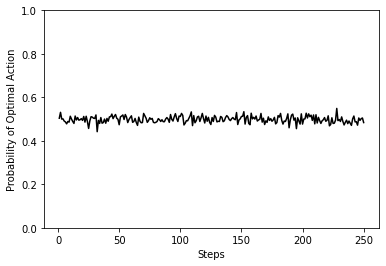

In [ ]:
df.loc[1].plot(legend=None,ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps",color="k");

As you can see, the optimal action is being selected half of the time, on average. This is the expected result for a random agent with two actions.

## Running the Experiment with Several Algorithms
Now let’s try and repeat with several different values of epsilon, the value that chooses the amount of time the algorithm chooses a random action. An epsilon of 0 would never choose a random action.

In [ ]:
df = pd.DataFrame()
for epsilon in [0, 0.1, 0.5, 1]:
    algo1 = EpsilonGreedy(epsilon, [], [])
    sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo1, arms, num_sims, horizon)

    arrays = [[epsilon] * num_sims * horizon, sim_nums, times]
    index = pd.MultiIndex.from_arrays(
        arrays, names=('epsilon', 'simulation', 'time'))
    df_chosen_arm = pd.DataFrame(chosen_arms, index=index)
    df_chosen_arm = df_chosen_arm.groupby(level=[0, 2]).sum() / num_sims
    df = df.append(df_chosen_arm)

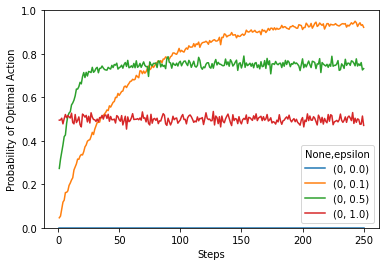

In [ ]:
df.unstack(level=0).plot(ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps");

Now there are several plots with different values of epsilon. You can see that when epsilon (the probability of exploration) is zero, then the agent never picks the optimal action. This is a bit of an implementation bug. The first time the agent picks an agent, it should be random. Eventualy, one of those actions is rewarding and it will subsequently pick the same action over an over again, without exploring other options.

Another thing you will notice is the speed of convergence. The less exploration there is, the longer it will take to reach an optimal value.

## Improving the ε-greedy Algorithm

All algorithms are fundamentally limited by how effectively they explore and how quickly they exploit. The best algorithms are able to do both at the same time, but defining how to explore is largely problem dependent. For example, a maze and an optimal healthcare schedule would require different exploration strategies.

The previous section showed that the hyperparameter ε controls this trade-off. Too high and the agent does too much searching, which results in choosing bad actions. Too low and the agent does too little searching and takes a long time to find new optimal actions.

The simulation also factors into this discussion. If the difference between the rewards of two actions is small, the agent has to sample these two outcomes a lot. According to the law of large numbers, the agent’s confidence bound on the reward becomes smaller with more observations.

It is often better to choose the action based upon the current estimates of the distribution of rewards. In other words, rather than returning a single action, the agent returns the probabilities of each action, weighted by expected rewards of each state. This is called a softmax function. This provides a natural exploration function defined by the current reward estimates.

If the eventual aim is to extract as much reward as possible, then there is no point continuing to explore. You could remove the ε-greedy action. But it is more common to reduce the value of  over time. This is called annealing. The word annealing comes from metallurgy. It means to heat and cool metals slowly, to strengthen and remove stresses.

A third popular improvement revolves around the idea that it doesn’t make sense to explore randomly, especially in simple simulations. The agent will learn more by exploring states that it hasn’t seen before. These algorithms add a bonus to each action for inadequately sampled states and are called upper-confidence-bound (UCB) methods. UCB algorithms are useful because they have no hyperparameters like ε (or the rate at which ε decreases, for annealing).

In essence, bandits generally use three forms of exploration. Standard ε-Greedy, which randomly chooses an action some proportion of the time, and annealing version, which reduces the exploration over time, and finally UCB, which chooses an action depending on how often the action has been sampled.

Define two adverts, with a probability of clicking from the users. This is a simulation. Imagine that these are real ads.

In [ ]:
arm0 = BernoulliArm(0.05)
arm1 = BernoulliArm(0.4)
arms = [arm0, arm1]

In [ ]:
random.seed(42)

num_sims = 1000 # Repetitions
horizon = 250 # Number of steps in experiment
n_arms = len(arms)

algo1 = AnnealingSoftmax([], []) # Annealing ε-Greedy
algo1.initialize(n_arms)
algo2 = EpsilonGreedy(0.05, [], []) # Standard ε-Greedy, exploring 5% of the time
algo3 = UCB1([], []) # UCB
algo3.initialize(n_arms)
algos = [("e_greedy", algo2), ("annealing_softmax", algo1), ("ucb", algo3)]

# A bit of code to loop over each algorithm and average the results
df = pd.DataFrame()
for algo in algos:
    sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo[1], arms, num_sims, horizon)
    arrays = [sim_nums, times]
    index = pd.MultiIndex.from_arrays(
        arrays, names=('simulation', 'time'))
    df_chosen_arm = pd.DataFrame(chosen_arms, index=index, columns=[algo[0]])
    df_probability_selected = df_chosen_arm.groupby(level=1).sum() / num_sims
    df = pd.concat([df, df_probability_selected], axis=1)

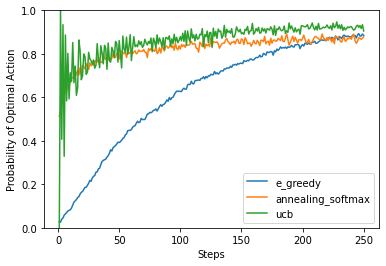

In [ ]:
df.plot(ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps");

You can see that the ε-Greedy algorithm is taking a long time to converge to a similar level of performance. The reason being that it is still spending a large proportion of the time chossing random actions.

The annealing version rapidly reduces the amount of random exploration to speed this learning up. This is better, but you need to tune the hyper-parameters (initial exploration rate, final exploration rate and how fast to anneal) for your specific problem.

UCB attempts to quantify the number of times that action/state has been explored. If it has been explored a lot, and it is not the best action, then there’s little point in exploring more. This is good because there are no hyper-parameters but you’ll need to store a representation UCB attempts to quantify the number of times that action/state has been explored. If it has been explored a lot, and it is not the best action, then there’s little point in exploring more. This is good because there are no hyper-parameters but you’ll need to store visitation counts; something that might not be possible for certain problems.